## Generate the SPECTRUM PLOTS

Model fitting to both spatial maps and spectra is one of the most common operations with spectral line data cubes, because it allows you to extract real physical information from interferometric data or a spectral cube.

I used the following link as a guide; https://radio-astro-tools.github.io/tutorials/fitting_with_spectralcube.html

#### SPECTRAL Fitting
Model how intensity varies with frequency or velocity. Essential for studying spectral line to obtain information about: 
- Central line velocity (→ gas movement).
- Line width (→ velocity dispersion, turbulence, thermal effects).
- Peak intensity (→ amount of emission, excitation temperature).
- Line profile (→ complex dynamics: multiple components, absorptions, outflows)


####     EXTRACT THE SPECTRUM

#### Generate this code for extract the spectrum in fixed position and in specifict region.

In this case the fixed point correspond the positiom used during the observation with APEX: 
- $(\alpha, \delta) =  (05:39:36.5, -69:45:35.00)$
------------------------------------------------------------------------------------------------------------------------------
For other hand, The region to extract the spectrum correspond one used in ALMA's observations, where the reference coordinate is: 
- $(\alpha, \delta) =  (05:39:36.6750, -69:46:00.260)$

The area is a rectangle maps of $90"\times 110"$


In [1]:
###### import the necessary libraries ######    
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from spectral_cube import SpectralCube
from astropy.io import fits
from tqdm import tqdm
from astropy.coordinates import SkyCoord, SkyOffsetFrame, SpectralQuantity
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.stats import mad_std
from astropy.modeling import models, fitting



In [22]:
#######  OPEN THE CUBE  #######
#path of the data
file = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CF+/CF+_N159_sci_VELaxis_inK_SPECT_RES.fits' #path of the data
#file = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CII/CII_N159_SPAT_RES.fits'
#file = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CF+/CF+_N159_sci_VELAXIS_SPECT_RES_29arc.fits' # ALMA AT 29"
cube = SpectralCube.read(file, format = 'fits', use_dask = True) #read the data
print(cube) #print the data
print(cube.header) #print the header
print('--------------------')


###############   SPECIFICT POSITION TO EXTRACT SPECTRUM  ##############
wcs = cube.wcs.celestial

# Define position to extract the spectrum (in RA and DEC)
coord = SkyCoord('05h39m36.5s', '-69d45m35.0s', frame='icrs') # used on proposal APEX
#coord = SkyCoord('05h39m37.8s', '-69d45m09.9s', frame='icrs') # position 1 in yoko et al. 2019

# RA y Dec en formato sexagesimal (HH:MM:SS, DD:MM:SS)
ra_str = coord.ra.to_string(unit=u.hour, sep=':', precision=3, pad=True)   
dec_str = coord.dec.to_string(unit=u.deg, sep=':', precision=3, alwayssign=True, pad=True) 
print('Coordinates to extract the spectrum (ICRS):', ra_str, dec_str)

# Transform to pixel coordinates
x1, y1 = wcs.world_to_pixel(coord)
# Rounding and converting to integers
pix_x, pix_y = int(np.rint(x1)), int(np.rint(y1))
print(f'Pixel coordinates rounded (from {file}): x={pix_x}, y={pix_y}')

############## SPECIFICT AREA TO EXTRACT THE SPECTRUM ##############
# Define the center coordinates of the region
center_coord = SkyCoord('05h39m36.6750s', '-69d45m00.260s', frame='icrs')  # Center coordinates used on proposal ALMA
# RA y Dec en formato sexagesimal (HH:MM:SS, DD:MM:SS)
ra_cen_str = center_coord.ra.to_string(unit=u.hour, sep=':', precision=3, pad=True)   
dec_cen_str = center_coord.dec.to_string(unit=u.deg, sep=':', precision=3, alwayssign=True, pad=True) 
print('Center coordinates (ICRS) of region:', ra_cen_str, dec_cen_str)
# Define the size of the region to mask (in arcseconds)
width = 90 * u.arcsec
height = 110 * u.arcsec

# Calculate the pixel scale (assuming square pixels)
center_x_pix, center_y_pix = skycoord_to_pixel(center_coord, wcs, origin=0)
# Rounding and converting to integers
cent_xpix, cent_ypix = int(np.rint(center_x_pix)), int(np.rint(center_y_pix))
print(f'Center pixel coordinates (from {file}): x={cent_xpix}, y={cent_ypix}')
print('--------------------')

########## OUTPUT FILES ##########
output_pix = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/TESTS/SPECT_POSITION_NORTH_CF_N159_SPECT_SPAT_RES_14ARC.fits' #path of the output spectrum
print('Output spectrum file:', output_pix)
#outut_area = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/TESTS/spectrum_area_CF+_N159.fits' #path of the output spectrum
#print('Output spectrum file:', outut_area)
print('--------------------')

## Necesitamos la velocidad de la luz para la aplicación de la fórmula Doppler
C = const.c.to(u.km / u.s).value * u.km/u.s  # Velocidad de la luz en km/s
print('\nVelocidad de la luz (C):', C)




DaskSpectralCube with shape=(731, 128, 120) and unit=K and chunk size (731, 128, 120):
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:    731  type_s: VRAD      unit_s: km / s  range:     -131.000 km / s:     599.000 km / s
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3                                                  NAXIS1  =                  120                                                  NAXIS2  =                  128                                                  NAXIS3  =                  731                                                  BMAJ    =   4.442253420057E-03                                                  BMIN    =   3.226777089219E-03                                                  BP

## 1-
Extract the necesarry information of the cube:

In [23]:
# Obtain essential information from the cubes
print('--------------------')
print('Información del cubo 1:')
RESTFRQ = cube.header['RESTFRQ'] * u.Hz
UNIT = cube.header['CUNIT3']
CRVAL = cube.header['CRVAL3'] * u.km/u.s
CRPIX = cube.header['CRPIX3']
CDELT = cube.header['CDELT3'] * u.km/u.s
NCHAN = cube.shape[0]
print('RESTFRQ:', RESTFRQ)
print('UNIT:', UNIT)
print('CRVAL:', CRVAL)
print('CRPIX:', CRPIX)
print('CRDELT:', CDELT)
print('NCHAN:', NCHAN)
print('--------------------')

# Obtain speed and frequency axes
index = np.arange(1, NCHAN + 1)
VEL = CRVAL + (index - CRPIX) * CDELT
print('Five first vel:', VEL[:5])
#FREQ = cube.with_spectral_unit(u.Hz, rest_value=RESTFRQ).spectral_axis.to(u.GHz)
#print('Five first freq:', FREQ[:5])
print('--------------------')


--------------------
Información del cubo 1:
RESTFRQ: 102587476000.0 Hz
UNIT: km s-1
CRVAL: -131.0 km / s
CRPIX: 1.0
CRDELT: 1.0 km / s
NCHAN: 731
--------------------
Five first vel: [-131. -130. -129. -128. -127.] km / s
--------------------


Start the extraction of spectrum and save in .FITS format, where we have ONE Axis (not three as in cube), so is necessary create a new HEADER. 

Five first intensity values: 0.03206087348702089
--------------------


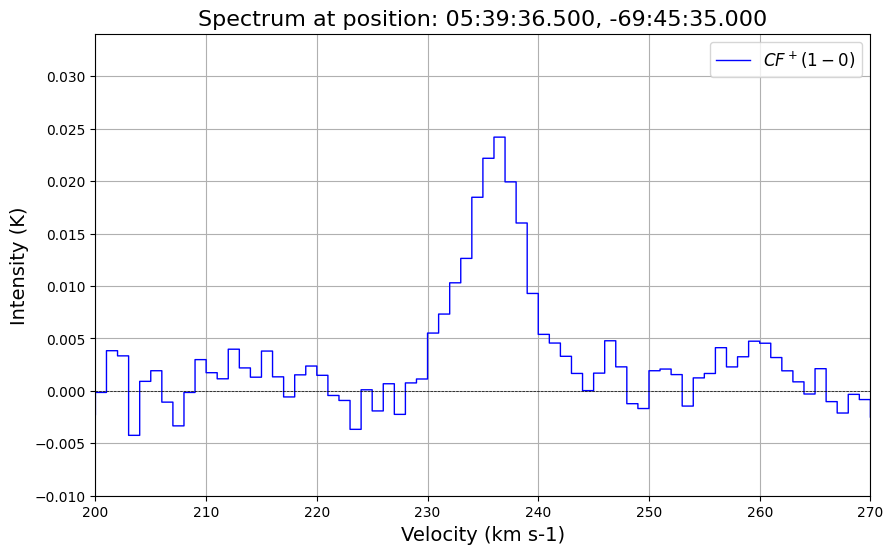

In [24]:
####### OBTAIN THE SPECTRUM #######
SPECT = cube[:, pix_y, pix_x]  # Extract the spectrum at the specified pixel
INTENSITY = SPECT.value  # Intensity values
print('Five first intensity values:', INTENSITY.max())
print('--------------------')

# View the spectrum
plt.figure(figsize=(10, 6))
plt.step(VEL, INTENSITY, color='blue', lw=1)
plt.xlabel(F'Velocity ({UNIT})', fontsize=14)
plt.ylabel(f'Intensity ({cube.header['BUNIT']})', fontsize=14)
plt.title(f'Spectrum at position: {ra_str}, {dec_str}' , fontsize=16)
plt.grid()
plt.xlim(200, 270)
plt.legend([r'$CF^+ (1-0)$'], fontsize=12)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.show()

In [25]:
#### CREATE A HEADER FOR THE SPECTRUM ####
# Crear un nuevo HDU para el espectro
hdu = fits.PrimaryHDU(INTENSITY)

# Copiar y adaptar el encabezado del cubo original
new_header = fits.Header()

# Copiar metadatos esenciales del cubo original
new_header['NAXIS'] = 1  # Espectro 1D
new_header['NAXIS1'] = len(INTENSITY)  # Longitud del espectro
new_header['CTYPE1'] = cube.header['CTYPE3']  # Tipo de eje (velocidad o frecuencia)
new_header['CUNIT1'] = cube.header['CUNIT3']  # Unidad del eje (e.g., km/s)
new_header['CRVAL1'] = cube.header['CRVAL3']  # Valor de referencia
new_header['CRPIX1'] = cube.header['CRPIX3']  # Píxel de referencia
new_header['CDELT1'] = cube.header['CDELT3']  # Incremento por píxel
new_header['RESTFRQ'] = cube.header['RESTFRQ']  # Frecuencia de reposo
new_header['BUNIT'] = cube.header['BUNIT']  # Unidad de la intensidad
new_header['BMAJ'] = cube.header.get('BMAJ', 0.0)  # Haz mayor (si aplica)
new_header['BMIN'] = cube.header.get('BMIN', 0.0)  # Haz menor (si aplica)
new_header['BPA'] = cube.header.get('BPA', 0.0)  # Ángulo de posición del haz (si aplica)

# Agregar información de las coordenadas de la posición extraída
new_header['RA'] = coord.ra.deg  # RA en grados
new_header['DEC'] = coord.dec.deg  # DEC en grados
new_header['EQUINOX'] = 'J2000'  # Sistema de coordenadas
new_header['COMMENT'] = f'Spectrum extracted at RA={ra_str}, DEC={dec_str}'

# Crear el HDU con el nuevo encabezado
hdu.header.update(new_header)

# Guardar el espectro en un archivo FITS
hdu.writeto(output_pix, overwrite=True) 
print(f'Spectrum saved to {output_pix}')

Spectrum saved to C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/TESTS/SPECT_POSITION_NORTH_CF_N159_SPECT_SPAT_RES_14ARC.fits


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    1                                                  NAXIS1  =                  731                                                  EXTEND  =                    T                                                  CTYPE1  = 'VRAD    '                                                            CUNIT1  = 'km s-1  '                                                            CRVAL1  =               -131.0                                                  CRPIX1  =                  1.0                                                  CDELT1  =                  1.0                                                  RESTFRQ =       102587476000.0                                                  BUNIT   = 'K       '                                                            BMAJ    =    0.004442253420057          

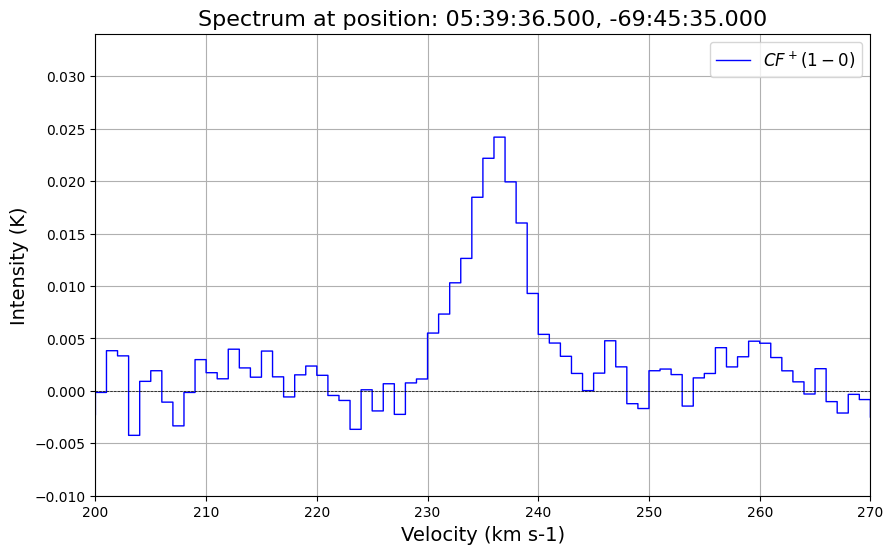

In [26]:
# Leer el archivo FITS

hdu = fits.open(output_pix)
spectrum = hdu[0].data  # Datos del espectro (intensidad)
header = hdu[0].header  # Encabezado con metadatos
hdu.close()
print(header)

# Extraer información del eje espectral (velocidad)
nchan = header['NAXIS1']  # Número de canales
crval = header['CRVAL1']  # Valor de referencia (km/s)
crpix = header['CRPIX1']  # Píxel de referencia
cdelt = header['CDELT1']  # Incremento por píxel (km/s)

bunit = header['BUNIT']   # Unidad de la intensidad
ra = header['RA']         # RA en grados
dec = header['DEC']       # DEC en grados

# Calcular el eje de velocidad
index = np.arange(1, nchan + 1)
vel = crval + (index - crpix) * cdelt  # Eje de velocidad en km/s

# Convertir RA y DEC a formato sexagesimal para el título
from astropy.coordinates import SkyCoord
import astropy.units as u
coord = SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
ra_str = coord.ra.to_string(unit=u.hour, sep=':', precision=3, pad=True)
dec_str = coord.dec.to_string(unit=u.deg, sep=':', precision=3, alwayssign=True, pad=True)

# Visualizar el espectro
plt.figure(figsize=(10, 6))
plt.step(vel, spectrum, color='blue', lw=1)
#plt.step(VEL, INTENSITY, color='red', lw=1)
plt.xlabel(f'Velocity (km s-1)', fontsize=14)
plt.ylabel(f'Intensity ({bunit})', fontsize=14)
plt.title(f'Spectrum at position: {ra_str}, {dec_str}', fontsize=16)
plt.grid()
plt.xlim(200, 270)  # Mantener el mismo rango que en tu gráfico original
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.legend([r'$CF^+ (1-0)$'], fontsize=12)
plt.show()

# 2-
Extract the spectrum into area an average this.


In [27]:
# Step 1: Convert region size from arcseconds to pixels
# Get the pixel scale from the WCS (in degrees per pixel)
pixel_scale = wcs.pixel_scale_matrix
pixel_scale_x = abs(pixel_scale[0, 0]) * u.deg  # Pixel scale in RA (degrees/pixel)
pixel_scale_y = abs(pixel_scale[1, 1]) * u.deg  # Pixel scale in Dec (degrees/pixel)
print(f'Pixel scale: {pixel_scale_x.to(u.arcsec)/u.pixel} in RA, {pixel_scale_y.to(u.arcsec)/u.pixel} in Dec')

# Convert width and height from arcseconds to pixels
width_pix = int(np.rint((width / pixel_scale_x).to(u.dimensionless_unscaled).value / 2))  # Half-width in pixels
height_pix = int(np.rint((height / pixel_scale_y).to(u.dimensionless_unscaled).value / 2))  # Half-height in pixels
print(f'Region size in pixels: width={2*width_pix}, height={2*height_pix}')

# Step 2: Define the rectangular region boundaries
x_min = cent_xpix - width_pix
x_max = cent_xpix + width_pix
y_min = cent_ypix - height_pix
y_max = cent_ypix + height_pix
print(f'Region boundaries: x=({x_min}, {x_max}), y=({y_min}, {y_max})')

# Ensure boundaries are within the cube dimensions
x_min = max(0, x_min)
x_max = min(cube.shape[2], x_max)  # cube.shape[2] is the x-axis (RA)
y_min = max(0, y_min)
y_max = min(cube.shape[1], y_max)  # cube.shape[1] is the y-axis (Dec)
print(f'Adjusted boundaries: x=({x_min}, {x_max}), y=({y_min}, {y_max})')

# Step 3: Create a mask for the region
mask = np.zeros(cube.shape[1:], dtype=bool)  # Shape of spatial dimensions (y, x)
mask[y_min:y_max, x_min:x_max] = True

# Apply the mask to the cube to extract the region
subcube = cube[:, y_min:y_max, x_min:x_max]
print(f'Subcube shape: {subcube.shape}')

Pixel scale: 2.30000000000004 arcsec / pix in RA, 2.30000000000004 arcsec / pix in Dec
Region size in pixels: width=40, height=48
Region boundaries: x=(41, 81), y=(66, 114)
Adjusted boundaries: x=(41, 81), y=(66, 114)
Subcube shape: (731, 48, 40)


In [28]:
# Step 4: Compute the average spectrum
# Mean over the spatial dimensions (y, x), keeping the spectral axis
spectrum = subcube.mean(axis=(1, 2))  # Average over spatial axes
print(f'Spectrum shape: {spectrum.shape}')
print(f'Five first intensity values of averaged spectrum: {spectrum.value[:5]}')

# Step 5: Create a new FITS file for the spectrum
# Create a new WCS for the 1D spectrum (spectral axis only)
wcs_spec = WCS(naxis=1)
wcs_spec.wcs.ctype = [cube.wcs.wcs.ctype[2]]  # Copy spectral axis type
wcs_spec.wcs.cunit = [cube.wcs.wcs.cunit[2]]  # Copy spectral axis unit
wcs_spec.wcs.crpix = [cube.wcs.wcs.crpix[2]]  # Reference pixel
wcs_spec.wcs.crval = [cube.wcs.wcs.crval[2]]  # Reference value
wcs_spec.wcs.cdelt = [cube.wcs.wcs.cdelt[2]]  # Pixel scale
wcs_spec.wcs.restfrq = cube.header['RESTFRQ']  # Rest frequency

Spectrum shape: (731,)
Five first intensity values of averaged spectrum: [ 7.45073845e-05  7.45073845e-05  1.56446383e-04 -1.03921881e-04
  5.01796352e-05]


In [29]:
# Inspeccionar un canal específico (por ejemplo, el canal 0)
print(subcube[0, :, :].value)  # Muestra la matriz de intensidades para el primer canal

[[ 4.31936833e-03  3.89784717e-03  3.64539276e-03 ...  1.19910649e-03
   1.34792115e-03  1.24662949e-03]
 [ 2.47046800e-03  1.99013961e-03  1.74307185e-03 ...  2.59878766e-03
   2.67143986e-03  2.38923391e-03]
 [ 4.81852358e-04  4.75550247e-05 -1.47876385e-04 ...  3.56711799e-03
   3.53874488e-03  3.13607956e-03]
 ...
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]]


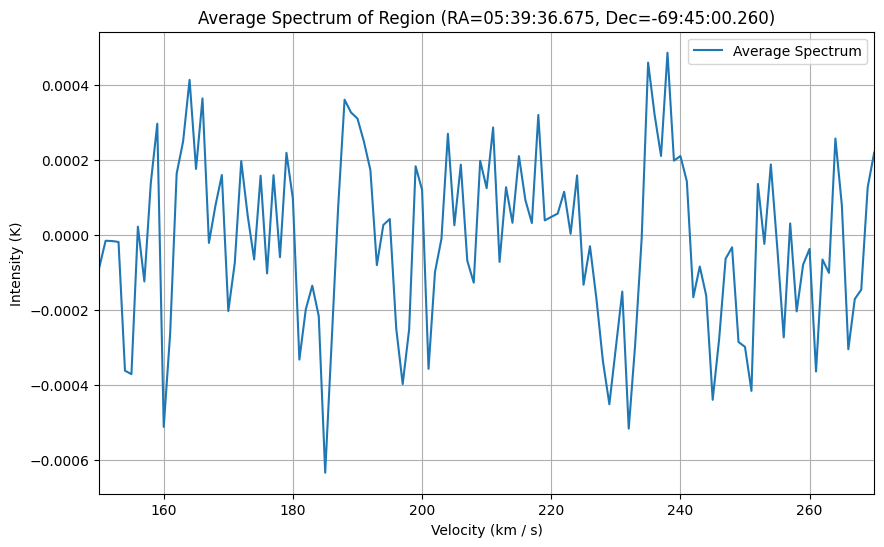

In [30]:
# Optional: Plot the spectrum for visualization
plt.figure(figsize=(10, 6))
plt.plot(VEL, spectrum, label='Average Spectrum')
plt.xlabel(f'Velocity ({VEL.unit})')
plt.ylabel(f'Intensity ({cube.unit})')
plt.xlim(150, 270)  # Mantener el mismo rango que en tu gráfico original
plt.title(f'Average Spectrum of Region (RA={ra_cen_str}, Dec={dec_cen_str})')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
# Create a new FITS header
hdu = fits.PrimaryHDU(data=spectrum.value, header=wcs_spec.to_header())
hdu.header['BUNIT'] = str(cube.unit)  # Copy the intensity unit from the cube
hdu.header['COMMENT'] = f'Average spectrum from region centered at RA={ra_cen_str}, Dec={dec_cen_str}'
hdu.header['COMMENT'] = f'Region size: {width} x {height}'
hdu.header['RESTFRQ'] = cube.header['RESTFRQ']

# Save the spectrum to a FITS file
hdu.writeto(outut_area, overwrite=True)
print(f'Spectrum saved to: {outut_area}')

NameError: name 'outut_area' is not defined